<div class="alert alert-success">
    <h1 align="center">Lesson 01: Image Classification (Cats vs Dogs)</h1>
    <h3 align="center"><a href="http://www.snrazavi.ir">Seyed Naser RAZAVI</a></h3>
</div>

<h6 align='center'>Kaggle competition: [Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)</h6>

<img src='imgs/catsanddogs.png' width='90%'/>

## Objectives

- Image classification
- Four key components of any ML system (in PyTorch):
 - Data (Images)
 - Model (CNN)
 - Loss (Cross Entropy)
 - Optimization (SGD, Adam, ..)
- Convolutional Neural Networks (CNNs)
- Overfit
- Data augmentation
- Transfer learning

## Image Classification

<img src='imgs/Image_tasks.jpg' width='80%'/>

## Libraries

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import math
import time
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

# Our libraries
from train import train_model
from model_utils import *
from predict_utils import *
from vis_utils import *

# some initial setup
np.set_printoptions(precision=2)
use_gpu = torch.cuda.is_available() # return True if your computer has GPU
np.random.seed(1234)

In [2]:
use_gpu

True

## Data

- train: learning the **parameters** of the model.
- valid: learning **hyper-parameters**.
- test
- development

## What Is a Batch?
Think of a batch as a for-loop iterating over one or more samples and making predictions.In this example, by determining batch size, we give model 32 images. A training dataset can be divided into batches.
When all training samples are used to create one batch, the learning algorithm is called batch gradient descent. When the batch is the size of one sample, the learning algorithm is called stochastic gradient descent. When the batch size is more than one sample and less than the size of the training dataset, the learning algorithm is called mini-batch gradient descent.


In the case of mini-batch gradient descent, popular batch sizes include 32, 64, and 128 samples. In the following cell, size of samples divide evenly by batch size(224/32=7).

In [3]:
DATA_DIR = 'D:/datasets/catsvsdogs/dev/'
sz = 224   # size of image
batch_size = 32

In [4]:
os.listdir(DATA_DIR)

['train', 'val', 'valid']

In [5]:
trn_dir = f'{DATA_DIR}train'
val_dir = f'{DATA_DIR}valid'

In [6]:
os.listdir(trn_dir)

['cat', 'dog']

In [7]:
trn_fnames = glob.glob(f'{trn_dir}/*/*.jpg')
trn_fnames[:5]

['D:/datasets/catsvsdogs/dev/train\\cat\\cat.1.jpg',
 'D:/datasets/catsvsdogs/dev/train\\cat\\cat.10.jpg',
 'D:/datasets/catsvsdogs/dev/train\\cat\\cat.100.jpg',
 'D:/datasets/catsvsdogs/dev/train\\cat\\cat.101.jpg',
 'D:/datasets/catsvsdogs/dev/train\\cat\\cat.102.jpg']

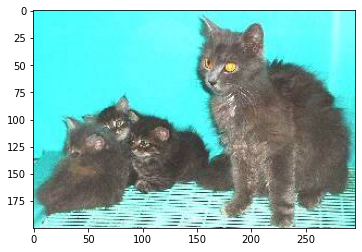

In [8]:
img = plt.imread(trn_fnames[3])
plt.imshow(img);

### Datasets and Dataloaders in PyTorch

- <h6>Dataset</h6>A set of images.
- <h6>Dataloader</h6>Loads data from dataset behind the scene using concurrent threads.

In [9]:
train_ds = datasets.ImageFolder(trn_dir)

In [10]:
train_ds.classes

['cat', 'dog']

In [11]:
train_ds.class_to_idx

{'cat': 0, 'dog': 1}

In [12]:
train_ds.root

'D:/datasets/catsvsdogs/dev/train'

In [13]:
# train_ds.imgs

In [14]:
# list(zip(*train_ds.imgs))

In [15]:
type(train_ds.transform)

NoneType

### Transformations

Dataloader object uses these tranformations when loading data.

In [16]:
tfms = transforms.Compose([
    transforms.Resize((sz, sz)),  # PIL Image( we need images with equal size)
    transforms.ToTensor(),        # Tensor (Matrix)
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # this line diduct mean and divid by std in the list.
])             # std:   These values come from the average standard deviation of images in a big dataset from imagenet.

train_ds = datasets.ImageFolder(trn_dir, transform=tfms)
valid_ds = datasets.ImageFolder(val_dir, transform=tfms)

In [17]:
len(train_ds), len(valid_ds)

(1600, 400)

#### Dataloaders

In [18]:
train_dl = torch.utils.data.DataLoader(train_ds, 
                                       batch_size=batch_size, # As shuffle True, pick 32 image accidentally
                                       shuffle=True, 
                                       num_workers=8)   # number of threads. Task of each thread: read and make ready 32(batch size) images in RAM, once the work of cpu done with las one, feed it instantly.
                                                        # that task of reading and prepare data to process is costly
valid_dl = torch.utils.data.DataLoader(valid_ds, 
                                       batch_size=batch_size, 
                                       shuffle=False, 
                                       num_workers=8)

##### The following cell is just to show how costly fetch data and prepar it (it takes seconds to prepare each iterate)

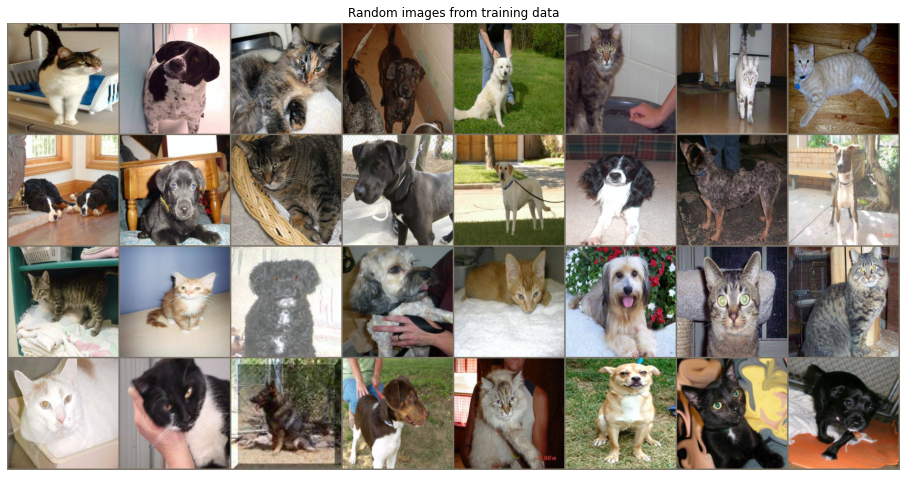

In [19]:
inputs, targets = next(iter(train_dl))
out = torchvision.utils.make_grid(inputs, padding=3)
plt.figure(figsize=(16, 12))
imshow(out, title='Random images from training data')

In [20]:
# ??imshow

## Model: CNN

<img src='imgs/DogAndCats-CNN.jpg' width='100%'/>

In [21]:
class SimpleCNN(nn.Module):
    
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Sequential(             # input layer size is sz*sz*channels -->224*224*3
            nn.Conv2d(3, 16, kernel_size=5, padding=2), # rgb has 3 channel, 16 filters, as filter is 5*5 the size of padding is 2
            nn.BatchNorm2d(16), # batch normalization make the training easier(optional)
            nn.ReLU(),
            nn.MaxPool2d(2) # maxpooling with stride of 2
        )
        
        self.conv2 = nn.Sequential(             # input layer size --> 112*112*32  because of maxpooling 224-->112  and channels is number of filters in last layer 16
            nn.Conv2d(16, 32, kernel_size=5, padding=2), #number of input image channel is 16 based on the number of filters in last layer. increase the number of filters(32) as the number of layers go up. 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc = nn.Linear(56 * 56 * 32, 2)  # # input layer size --> 56*56*32,   2 neurons as output as we have 2 class of dog and cat
        
    def forward(self, x):    # we can write the backward function and override it. otherwise, pytourch make the graph and do the derivative and backward propagation itself.
        out = self.conv1(x)
        out = self.conv2(out)            # (bs, C, H,  W)
        out = out.view(out.size(0), -1)  # (bs, C * H, W)
        out = self.fc(out)
        return out

# GPU:
#### Now, it's time to create the model and to put it on the GPU.
Tensors(matrix) on pytourch are able to be proccessed on GPU, while numpy matrix can only be processed by CPU.

In [22]:
model = SimpleCNN()

# transfer model to GPU, if gpu is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # transfer processing to GPU if computer has GPU

model = model.to(device)

In [23]:
model

SimpleCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=100352, out_features=2, bias=True)
)

## Loss function and optimizer

In [24]:
criterion = nn.CrossEntropyLoss()  # define loss function
optimizer = optim.SGD(model.parameters(), # define optimizer, determine that do optimize with respect to parameters, 
                      lr=0.002,   # learning rate=0.002,
                      momentum=0.9) #  momentum: helps accelerate gradients vectors in the right directions, thus leading to faster converging.

## What Is an Epoch?
You can think of a for-loop over the number of epochs where each loop proceeds over the training dataset. Within this for-loop is another nested for-loop that iterates over each batch of samples, where one batch has the specified “batch size” number of samples. In this example, for each epoch, it iterate over 32 sample for training.

The number of epochs is traditionally large, often hundreds or thousands, allowing the learning algorithm to run until the error from the model has been sufficiently minimized. You may see examples of the number of epochs in the literature and in tutorials set to 10, 100, 500, 1000, and larger.

It is common to create line plots that show epochs along the x-axis as time and the error or skill of the model on the y-axis. These plots are sometimes called learning curves. These plots can help to diagnose whether the model has over learned, under learned, or is suitably fit to the training dataset.

## Train

In [25]:
num_epochs = 10
losses = []

for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_dl): # if we have 1000 images for development phase, it feed NN equvalent of batch size imges. here means it give 32 by 32 images 
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        # forwad pass
        outputs = model(inputs)
        
        # loss
        loss = criterion(outputs, targets)
        losses.append(loss.item())

        # backward pass
        optimizer.zero_grad()
        loss.backward()  # W= W- Lr*dW
        
        # update parameters
        optimizer.step()
        
        # report
        if (i + 1) % 50 == 0:
            print('Epoch [%2d/%2d], Step [%3d/%3d], Loss: %.4f'
                  % (epoch + 1, num_epochs, i + 1, len(train_ds) // batch_size, loss.item()))

Epoch [ 1/10], Step [ 50/ 50], Loss: 3.9289
Epoch [ 2/10], Step [ 50/ 50], Loss: 0.7521
Epoch [ 3/10], Step [ 50/ 50], Loss: 0.7782
Epoch [ 4/10], Step [ 50/ 50], Loss: 0.4212
Epoch [ 5/10], Step [ 50/ 50], Loss: 0.7384
Epoch [ 6/10], Step [ 50/ 50], Loss: 0.3774
Epoch [ 7/10], Step [ 50/ 50], Loss: 0.5309
Epoch [ 8/10], Step [ 50/ 50], Loss: 0.2147
Epoch [ 9/10], Step [ 50/ 50], Loss: 0.2003
Epoch [10/10], Step [ 50/ 50], Loss: 0.1655


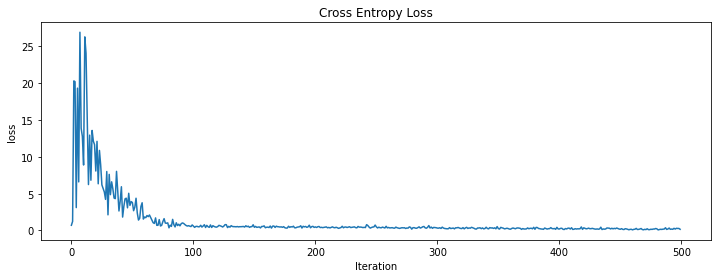

In [26]:
plt.figure(figsize=(12, 4))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.title('Cross Entropy Loss')
plt.show()

### Analyze results

#### Accuracy on validation data

In [27]:
def evaluate_model(model, dataloader, device):
    model.eval()  # for batch normalization layers
    corrects = 0
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += (preds == targets.data).sum()
    
    print('accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset)))

In [28]:
evaluate_model(model, valid_dl, device)

accuracy: 64.00


In [29]:
evaluate_model(model, train_dl, device)

accuracy: 96.62


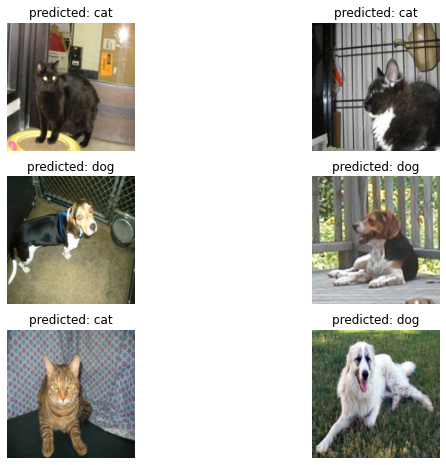

In [30]:
visualize_model(model, train_dl, device)

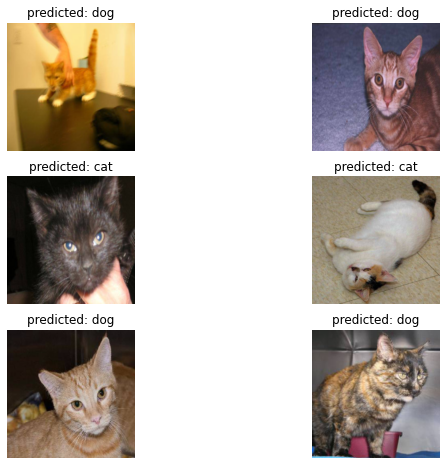

In [31]:
visualize_model(model, valid_dl, device)

100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


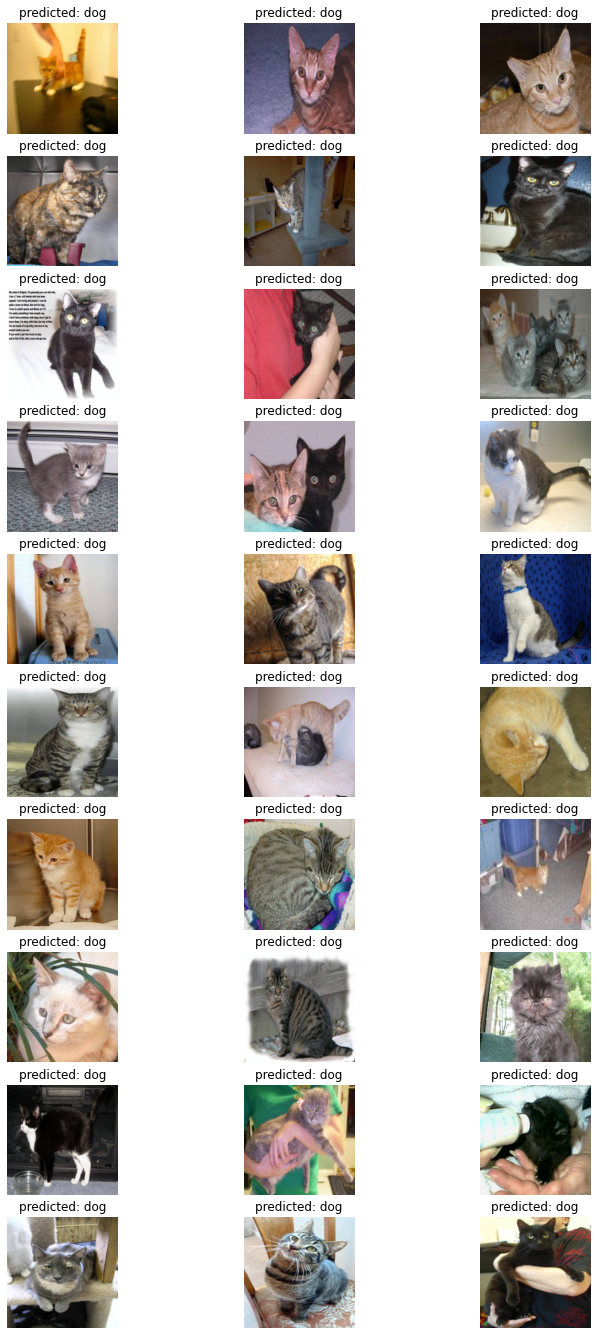

42 images out of 400 were misclassified.


In [32]:
plot_errors(model, valid_dl, device)

#### Confusion matrix

100%|██████████| 13/13 [00:04<00:00,  2.87it/s]

[[0.57 0.43]
 [0.29 0.71]]


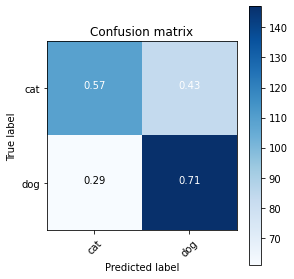

In [33]:
y_pred, y_true = predict_class(model, valid_dl, device)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, train_ds.classes, normalize=True, figsize=(4, 4))

## Overfit

<div class="alert alert-success">
    <strong>What is OVERFIT? </strong>
    <ul>
        <li>The most important concept in ML!</li>
        <li>Simply, it means that your model is too complex for your problem.</li>
    </ul>
</div>

<h6>What we can do about it?</h6>

- Regularization
- Dropout
- Data Augmentation
- Transfer Learning

## Data Augmentation

<img src='imgs/Augmentation.jpg' width='90%'/>

<h6>Possible Transformations:</h6>
- Scaling
- Rotation
- Translation
- Flip horizontaly
- Random Crop
- Color jitter
- many more!

<img src='imgs/Augmentation-Examples.jpg' width='75%'/>

In [34]:
# Data augmentation and normalization for training
train_transforms = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.01),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Just normalization for validation
valid_transforms = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(f'{DATA_DIR}train', train_transforms)
valid_ds = datasets.ImageFolder(f'{DATA_DIR}valid', valid_transforms)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, shuffle=True)

train_ds_sz = len(train_ds)
valid_ds_sz = len(valid_ds)

print('Train size: {}\nValid size: {} ({:.2f})'.format(train_ds_sz, valid_ds_sz, valid_ds_sz/(train_ds_sz + valid_ds_sz)))

class_names = train_ds.classes

Train size: 1600
Valid size: 400 (0.20)


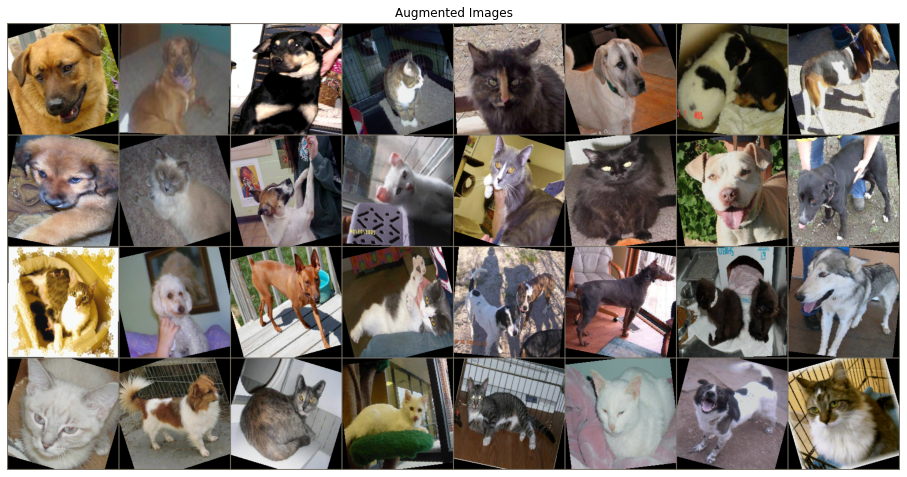

In [35]:
inputs, targets = next(iter(train_dl))     # Get a batch of training data
out = torchvision.utils.make_grid(inputs)  # Make a grid from batch
plt.figure(figsize=(16., 12.))
imshow(out, title='Augmented Images');

#### Look at the sizes of the images

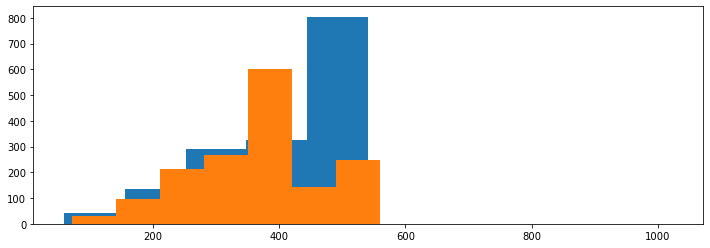

In [36]:
fnames = glob.glob(f'{trn_dir}/*/*.jpg')
sizes = [Image.open(f).size for f in fnames]

hs, ws = list(zip(*sizes))

plt.figure(figsize=(12., 4.))
plt.hist(hs)
plt.hist(ws);

In [37]:
# create model
model = SimpleCNN()
model = model.to(device)
    
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)

# train
model = train_model(model, train_dl, valid_dl, criterion, optimizer, device, num_epochs=5)

Epoch 1/5
----------
  train Loss: 6.83803 Acc: 0.53312
  valid Loss: 2.83796 Acc: 0.54250

Epoch 2/5
----------
  train Loss: 1.50674 Acc: 0.55875
  valid Loss: 0.91513 Acc: 0.57750

Epoch 3/5
----------
  train Loss: 0.76810 Acc: 0.60750
  valid Loss: 0.75562 Acc: 0.54500

Epoch 4/5
----------
  train Loss: 0.64281 Acc: 0.63875
  valid Loss: 0.74178 Acc: 0.54250

Epoch 5/5
----------
  train Loss: 0.60709 Acc: 0.67437
  valid Loss: 0.67934 Acc: 0.60500

Training complete in 1m 16s
Best val Acc: 0.6050


## Transfer Learning

- Use a CNN already trained on different data (e.g., [ImageNet](http://www.image-net.org/))
- Just Train the classifier weights (Last Layer)

<img src='imgs/transfer-learning.jpg' width='80%'/>

In [38]:
# load pre-trained ResNet18
model = load_pretrained_resnet50(model_path=None, num_classes=2)
model = model.to(device)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

In [39]:
model = train_model(model, train_dl, valid_dl, criterion, optimizer, device, scheduler, num_epochs=2)

Epoch 1/2
----------
  train Loss: 0.20153 Acc: 0.90937
  valid Loss: 0.04781 Acc: 0.98000

Epoch 2/2
----------
  train Loss: 0.05938 Acc: 0.98375
  valid Loss: 0.05671 Acc: 0.98500

Training complete in 0m 40s
Best val Acc: 0.9850


In [40]:
evaluate_model(model, valid_dl, device)

accuracy: 98.50


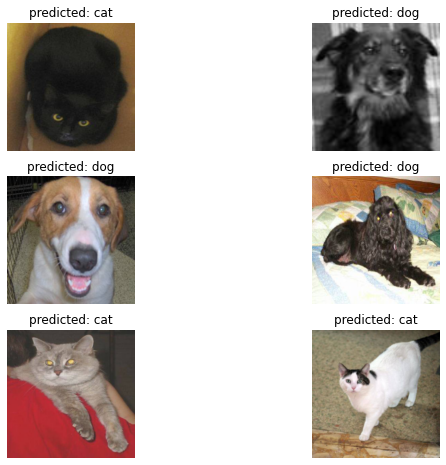

In [41]:
visualize_model(model, valid_dl, device, num_images=6)

100%|██████████| 13/13 [00:02<00:00,  5.72it/s]


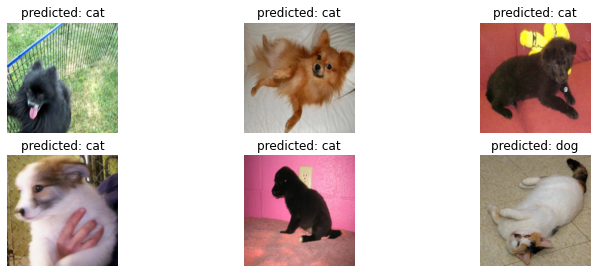

6 images out of 400 were misclassified.


In [42]:
plot_errors(model, valid_dl, device)

## PROGRAMMING ASSIGNMENT 1

<div class="alert alert-success">
    <strong>[Plant Seeldlings Competition](https://www.kaggle.com/c/plant-seedlings-classification)</strong>
    <img src='imgs/PlantSeedling.png'/>
    <ul>
        <li><strong>Objective:</strong> getting a rank among top 50% in LB.</li>
        <li><strong>Ideas:</strong> different augmentations, different architectures, etc.</li>
        <li><strong>Important:</strong> share your ideas and progress on Piazza.</li>
    </ul>
</div>